In [497]:
import pandas as pd
import numpy as np
import get_trands as gt
import matplotlib.pyplot as plt
from fbprophet import Prophet
import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
import math
from itertools import combinations
from itertools import product
import time
from progress.bar import IncrementalBar
from tqdm import tqdm
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [498]:
df = pd.read_csv('all_data.csv')
df = df.fillna(method = 'ffill')
df = df.fillna(method = 'bfill')
df['y'] = df.hc
df['ds'] = pd.to_datetime(df['ds'])

In [499]:
df_2 = pd.read_csv('SHFEHC.csv')
df_2 = df_2.fillna(method = 'ffill')
df_2 = df_2.fillna(method = 'bfill')
df_2['y'] = df_2.Settle
df_2['ds'] = pd.to_datetime(df_2['Date'])

In [500]:
offset_days = 365

In [501]:
model_period = np.arange(start=4, stop=5, step=1) 
n_changepoints = np.arange(start=15, stop=20, step=1)             # max 25
changepoint_range =  np.arange(start=0.5, stop=1, step=0.2)          # max 1
changepoint_prior_scale = np.arange(start=0.5, stop=1, step=0.1)    # max 1
seasonality_prior_scale =  np.arange(start=0.1, stop=0.5, step=0.1)   # max 1
regressor_prior_scale =  np.arange(start=0.1, stop=0.5, step=0.1)   # max 1

In [502]:
params = list(product(model_period, n_changepoints, changepoint_range, changepoint_prior_scale, seasonality_prior_scale, regressor_prior_scale))

In [503]:
len(params)

1200

In [504]:
len(params)*2.66/60/60

0.8866666666666667

In [506]:
def create_forecast_regressors(df, forecast_period = 90):
    predict_regrs = []
    for r in df.columns[3:-1]:
        reg = str(r)
        temp_df = df[['ds', r ]].copy()
        temp_df.rename(columns={r: 'y'}, inplace=True)
        r = Prophet(daily_seasonality=False, weekly_seasonality = False)
        r.fit(temp_df)
        future = r.make_future_dataframe(periods=forecast_period)
        forecast = r.predict(future)
        start_forecast = max(forecast['ds']) - pd.DateOffset(days=forecast_period)
        forecast = forecast[['ds', 'yhat']]
       
        forecast[reg] = forecast[forecast.columns[1]]
        forecast = forecast.drop(forecast.columns[1], axis='columns')
        forecast = forecast.fillna(method = 'ffill')
        forecast = forecast.fillna(method = 'bfill')
        predict_regrs.append(forecast)
    return predict_regrs

In [623]:
def forecast(params, df, fdf, regressor_list, forecast_period, plot_period, b_start=3, b_end=-1):
    start_model = max(df['ds']) - pd.DateOffset(years=param[0])
    start_plot = max(df['ds']) - pd.DateOffset(years=plot_period)
    train = df[(df['ds'] >= start_model)] 
    fdf = fdf[(fdf['ds'] >= max(df['ds']))] 
    m = Prophet(
        n_changepoints = param[1], 
        changepoint_range = param[2], 
        changepoint_prior_scale = param[3], 
        seasonality_prior_scale = param[4],
        yearly_seasonality = True, 
        weekly_seasonality = False,
        daily_seasonality = False
    )
    for r in df.columns[b_start:b_end]:
        print(r)
        m.add_regressor(r, prior_scale = param[5])
    m.fit(train)

    future = m.make_future_dataframe(periods=forecast_period)
    for r in range(len(regressors_list)):
        future = future.merge(regressors_list[r], left_on = 'ds', right_on = 'ds', how = "left")
# #     future = future.fillna(method = 'ffill')
 
    forecast = m.predict(future)

    calculate = forecast[['ds','yhat']]
    observed = df[['ds','y']]
    results = calculate.merge(observed, left_on = 'ds', right_on = 'ds', how = "left")
    results.loc[results['y'].isnull(), 'y'] = results['y'].fillna(method = 'ffill')
    
    R2 = r2_score(list(results['y']), list(results['yhat']))
    MAE = r2_score(list(results['y']), list(results['yhat']))
    MSE = mean_squared_error(list(results['y']), list(results['yhat']))
    max_e = max_error(list(results['y']), list(results['yhat'])) 
                             
    print(f'R2 = {R2}')
    print(f'MAE = {MAE}')
    print(f'MSE = {MSE}')
    print(f'max_error = {max_e}')
    
    result = calculate[(calculate['ds'] >= max(calculate['ds']) - pd.DateOffset(days=forecast_period))]
    
    train_plot = train[(train['ds'] >= start_plot)]
    forecast_plot = forecast[(forecast['ds'] >= start_plot)]
    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    # Plot the actual values
    ax.plot(train_plot['ds'], train_plot['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Наблюдения train')
    
     # Plot the actual values
    ax.plot(fdf['ds'], fdf['y'], 'go-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Наблюдения train')
    
    # Plot the aprocsimated values
    ax.plot(forecast_plot['ds'], forecast_plot['yhat'], 'ro-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Actual')

    # Plot the predicted values
    ax.plot(result['ds'], result['yhat'], 'bo-', linewidth = 0.5, alpha = 0.8, ms = 1.5, label = 'Прогноз'); #'navy'
               
  # Plot formatting
    plt.legend(loc = 2, prop={'size': 8}); plt.xlabel('Date'); plt.ylabel('Price');
    plt.grid(linewidth=0.6, alpha = 0.6)

    plt.show();
               
    return m, result, forecast

In [691]:
def forecast_M0(params, df, fdf, forecast_period, plot_period):
    start_model = max(df['ds']) - pd.DateOffset(years=param[0])
    start_plot = max(df['ds']) - pd.DateOffset(years=plot_period)
    train = df[(df['ds'] >= start_model)] 
    fdf = fdf[(fdf['ds'] >= max(df['ds']))] 
    m = Prophet(
        n_changepoints = param[1], 
        yearly_seasonality = True, 
        weekly_seasonality = False,
        daily_seasonality = False
    )
    
    m.fit(train)

    future = m.make_future_dataframe(periods=forecast_period)
    
    forecast = m.predict(future)

    calculate = forecast[['ds','yhat']]
    observed = df[['ds','y']]
    results = calculate.merge(observed, left_on = 'ds', right_on = 'ds', how = "left")
    results.loc[results['y'].isnull(), 'y'] = results['y'].fillna(method = 'ffill')
    
    R2 = r2_score(list(results['y']), list(results['yhat']))
    MAE = r2_score(list(results['y']), list(results['yhat']))
    MSE = mean_squared_error(list(results['y']), list(results['yhat']))
    max_e = max_error(list(results['y']), list(results['yhat'])) 
                             
    print(f'R2 = {R2}')
    print(f'MAE = {MAE}')
    print(f'MSE = {MSE}')
    print(f'max_error = {max_e}')
    
    result = calculate[(calculate['ds'] >= max(calculate['ds']) - pd.DateOffset(days=forecast_period))]
    
    train_plot = train[(train['ds'] >= start_plot)]
    forecast_plot = forecast[(forecast['ds'] >= start_plot)]
    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    # Plot the actual values
    ax.plot(train_plot['ds'], train_plot['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Наблюдения train')
    
     # Plot the actual values
    ax.plot(fdf['ds'], fdf['y'], 'go-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Наблюдения train')
    
    # Plot the aprocsimated values
    ax.plot(forecast_plot['ds'], forecast_plot['yhat'], 'ro-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Actual')

    # Plot the predicted values
    ax.plot(result['ds'], result['yhat'], 'bo-', linewidth = 0.5, alpha = 0.8, ms = 1.5, label = 'Прогноз'); #'navy'
               
  # Plot formatting
    plt.legend(loc = 2, prop={'size': 8}); plt.xlabel('Date'); plt.ylabel('Price');
    plt.grid(linewidth=0.6, alpha = 0.6)

    plt.show();
               
    return m, result, forecast

In [730]:
def forecast_M12(params, df, fdf, forecast_period, plot_period):
    start_model = max(df['ds']) - pd.DateOffset(years=param[0])
    start_plot = max(df['ds']) - pd.DateOffset(years=plot_period)
    train = df[(df['ds'] >= start_model)] 
    fdf = fdf[(fdf['ds'] >= max(df['ds']))] 
    m = Prophet(
        n_changepoints = param[1], 
        changepoint_range = param[2], 
        changepoint_prior_scale = param[3], 
        seasonality_prior_scale = param[4],
        yearly_seasonality = True, 
        weekly_seasonality = False,
        daily_seasonality = False
    )
    
    m.fit(train)

    future = m.make_future_dataframe(periods=forecast_period)
    
    forecast = m.predict(future)

    calculate = forecast[['ds','yhat']]
    observed = df[['ds','y']]
    results = calculate.merge(observed, left_on = 'ds', right_on = 'ds', how = "left")
    results.loc[results['y'].isnull(), 'y'] = results['y'].fillna(method = 'ffill')
    
    R2 = r2_score(list(results['y']), list(results['yhat']))
    MAE = r2_score(list(results['y']), list(results['yhat']))
    MSE = mean_squared_error(list(results['y']), list(results['yhat']))
    max_e = max_error(list(results['y']), list(results['yhat'])) 
                             
    print(f'R2 = {R2}')
    print(f'MAE = {MAE}')
    print(f'MSE = {MSE}')
    print(f'max_error = {max_e}')
    
    result = calculate[(calculate['ds'] >= max(calculate['ds']) - pd.DateOffset(days=forecast_period))]
    
    train_plot = train[(train['ds'] >= start_plot)]
    forecast_plot = forecast[(forecast['ds'] >= start_plot)]
    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    # Plot the actual values
    ax.plot(train_plot['ds'], train_plot['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Наблюдения train')
    
     # Plot the actual values
    ax.plot(fdf['ds'], fdf['y'], 'go-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Наблюдения train')
    
    # Plot the aprocsimated values
    ax.plot(forecast_plot['ds'], forecast_plot['yhat'], 'ro-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Actual')

    # Plot the predicted values
    ax.plot(result['ds'], result['yhat'], 'bo-', linewidth = 0.5, alpha = 0.8, ms = 1.5, label = 'Прогноз'); #'navy'
               
  # Plot formatting
    plt.legend(loc = 2, prop={'size': 8}); plt.xlabel('Date'); plt.ylabel('Price');
    plt.grid(linewidth=0.6, alpha = 0.6)

    plt.show();
               
    return m, result, forecast

In [508]:
def analis_model(params, df):
    res_params = []
    for param in tqdm(params):
    
        start_model = max(df['ds']) - pd.DateOffset(years=param[0])
        start_forecast = max(df['ds']) - pd.DateOffset(days=offset_days)
        train = df[(df['ds'] >= start_model) & (df['ds'] <= start_forecast)]
        test = df[(df['ds'] > start_forecast)]

        m = Prophet(
            n_changepoints = param[1], 
            changepoint_range = param[2], 
            changepoint_prior_scale = param[3], 
            seasonality_prior_scale = param[4],
            yearly_seasonality = True, 
            weekly_seasonality = False,
            daily_seasonality = False
        )

        for r in df.columns[3:-1]:
            m.add_regressor(r, prior_scale = param[5])
        m.fit(train)

        future = m.make_future_dataframe(periods=offset_days)
        future = future.merge(df, left_on = 'ds', right_on = 'ds', how = "left")
        future = future.fillna(method = 'ffill')

        forecast = m.predict(future)

        calculate = forecast[['ds','yhat']]
        observed = df[['ds','y']]
        results = calculate.merge(observed, left_on = 'ds', right_on = 'ds', how = "left")
        results.loc[results['y'].isnull(), 'y'] = results['y'].fillna(method = 'ffill')
        train_results = results.loc[results['ds'] <= start_forecast]
        test_results = results.loc[results['ds'] > start_forecast]
        r2_train = r2_score(list(train_results['y']), list(train_results['yhat']))
        r2_test = r2_score(list(test_results['y']), list(test_results['yhat']))

        res_params.append([r2_train,r2_test, param[0], param[1], param[2], param[3], param[4], param[5]])
    
    return res_params

In [509]:
def choos_model(params, df, initial=1095, period=30, horizon = 30, rolling_window_days = 7):
    res_params = []
    best_metrics = []
    for param in tqdm(params):
    
        start_model = max(df['ds']) - pd.DateOffset(years=param[0])
        train = df[(df['ds'] >= start_model)]

        m = Prophet(
            n_changepoints = param[1], 
            changepoint_range = param[2], 
            changepoint_prior_scale = param[3], 
            seasonality_prior_scale = param[4],
            yearly_seasonality = True, 
            weekly_seasonality = False,
            daily_seasonality = False
        )

        for r in df.columns[3:-1]:
            m.add_regressor(r, prior_scale = param[5])
        
       
        m.fit(train)

        df_cv = cross_validation(m, initial=str(initial)+' days', period=str(period)+' days', horizon = str(horizon)+' days')
        df_p = performance_metrics(df_cv, rolling_window = rolling_window_days/horizon)
        
#         res_params.append([param[0], param[1], param[2], param[3], param[4], param[5]])
        best_metrics.append([df_p, param[0], param[1], param[2], param[3], param[4], param[5]])
    return best_metrics

In [723]:
def model_1(params, df, initial, period=30, horizon = 30):
    ''' смотрим лучшие модели по комбинациям периода обучения и количества точек n_changepoints'''
    res_params = []
    best_metrics = []
    for param in tqdm(params):
    
        start_model = max(df['ds']) - pd.DateOffset(years=4)
        train = df[(df['ds'] >= start_model)]

        m = Prophet(
            n_changepoints = param[0],
            changepoint_range = param[1], 
            changepoint_prior_scale = param[2], 
            seasonality_prior_scale = param[3],
            yearly_seasonality = True, 
            weekly_seasonality = False,
            daily_seasonality = False
        )

        m.fit(train)
#         initial = int(0.5 * param[0] * 365) initial=str(initial)+' days',
        df_cv = cross_validation(m,  initial=str(initial)+' days', period=str(period)+' days', horizon = str(horizon)+' days')
        df_p = performance_metrics(df_cv, rolling_window = 1)
        
        best_metrics.append([df_p, param[0], param[1], param[2], param[3]])
    return best_metrics

n_changepoints = np.arange(start=10, stop=25, step=1)             # max 25
changepoint_range =  np.arange(start=0.7, stop=1, step=0.5)          # max 1
changepoint_prior_scale = np.arange(start=0.1, stop=0.8, step=0.2)    # max 1
seasonality_prior_scale =  np.arange(start=0.05, stop=0.5, step=0.05)   # max 1
params = list(product(n_changepoints, changepoint_range, changepoint_prior_scale, seasonality_prior_scale))
print(f'количество итераций: {len(params)}, время выполнения: {len(params)*30/60} минут')

# фиксируем самые лучшие параметры [4, 17] M0 (горизонт 90 дней)
# horizon	mse	rmse	mae	mape	mdape	coverage
# 0	90 days	238970.490208	488.84608	388.113598	0.100298	0.086284	0.246862

# фиксируем наилучшие параметры для M1 (горизонт 90 дней) без регрессоров
# 0	1	2	3	4
# 260	0.093841	160756.086544	334.560998	0.257384	[4, 17, 0.7, 0.1, 0.45] без регрессоров

# фиксируем наилучшие параметры для M2 (горизонт 30 дней) без регрессоров



количество итераций: 540, время выполнения: 270.0 минут


In [735]:
# cv = model_1(params, df,  initial = 365 * 3, period=30, horizon = 30)

In [510]:
model_period = np.arange(start=4, stop=5, step=1) 
n_changepoints = np.arange(start=15, stop=25, step=5)             # max 25
changepoint_range =  np.arange(start=0.8, stop=1, step=0.1)          # max 1
changepoint_prior_scale = np.arange(start=0.1, stop=0.6, step=0.2)    # max 1
seasonality_prior_scale =  np.arange(start=0.1, stop=0.4, step=0.1)   # max 1
regressor_prior_scale =  np.arange(start=0.1, stop=0.5, step=0.1)   # max 1

In [511]:
params = list(product(model_period, n_changepoints, changepoint_range, changepoint_prior_scale, seasonality_prior_scale, regressor_prior_scale))

In [729]:
cv[260][0]

,horizon,mse,rmse,mae,mape,mdape,coverage
0,90 days,160756.086544,400.943994,334.560998,0.093841,0.087967,0.257384


In [727]:
metrics = []
for i in range(len(cv)):
    metrics.append([cv[i][0].mape[0], cv[i][0].mse[0], cv[i][0].mae[0], cv[i][0].coverage[0], cv[i][1:]])
top = pd.DataFrame(metrics).sort_values(by=0, ascending=True)
top.head()

,0,1,2,3,4
260,0.093841,160756.086544,334.560998,0.257384,"[17, 0.7, 0.1, 0.45]"
252,0.094178,160972.551295,335.662061,0.278481,"[17, 0.7, 0.1, 0.05]"
254,0.094188,162128.260319,335.583842,0.270042,"[17, 0.7, 0.1, 0.15000000000000002]"
291,0.094231,156944.288546,335.481208,0.274262,"[18, 0.7, 0.1, 0.2]"
258,0.094246,161046.921905,335.823807,0.270042,"[17, 0.7, 0.1, 0.35000000000000003]"


In [485]:
regressors_list = create_forecast_regressors(df, forecast_period = 90)

R2 = 0.8884979798187252
MAE = 0.8884979798187252
MSE = 17503.516383783273
max_error = 411.1447893237755


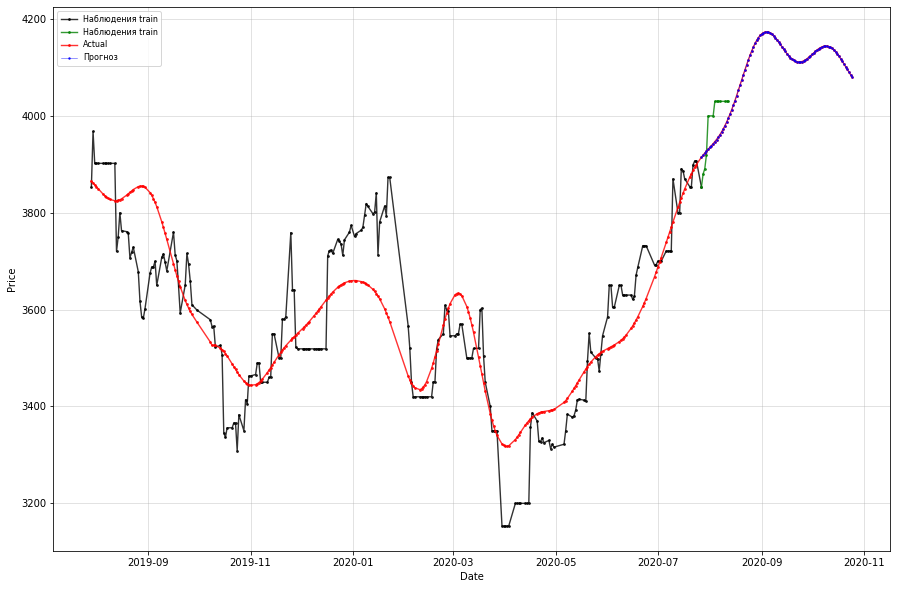

In [701]:
param = [4, 17]
f = forecast_M0(param, df, df_2, 90, 1)

R2 = 0.7929321151264885
MAE = 0.7929321151264885
MSE = 32505.385189850836
max_error = 661.8332790534914


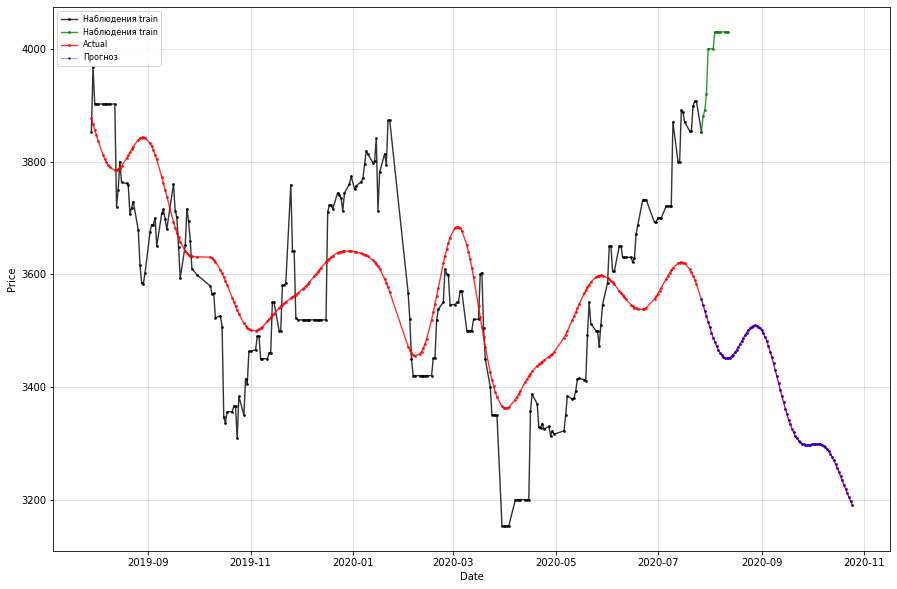

In [734]:
param = [4, 17, 0.7, 0.1, 0.45]
f1 = forecast_M12(param, df, df_2, 90, 1)

In [ ]:
fig1 = m.plot_components(forecast)

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mape')